In [ ]:
import pickle

# Load the file
with open('greedy_training_data.pkl', 'rb') as f:
    data = pickle.load(f)


training_data = data['training_data']
assignment_history = data['assignment_history']
depots = data['depots']  # List of tuples: (id, location, capacity)
drone_specs = data['drone_specs']

# Example prints
print("Number of training samples:", len(training_data))
print("First depot:", depots[0])
print("Drone specs:", drone_specs)

In [ ]:
import pickle
import os
from dataclasses import dataclass
from typing import Tuple
from enum import Enum

# Define the classes needed to unpickle the data
class OrderPriority(Enum):
    LOW = 1
    MEDIUM = 2
    HIGH = 3
    EMERGENCY = 4

@dataclass
class Depot:
    id: int
    location: Tuple[float, float]

@dataclass
class Order:
    id: int
    pickup_location: Tuple[float, float]
    delivery_location: Tuple[float, float]
    priority: OrderPriority
    arrival_time: float
    deadline: float
    weight: float = 1.0
    score: int = 0

def examine_pkl_file(filename: str):
    """Examine the contents of a .pkl file"""
    
    if not os.path.exists(filename):
        print(f"File {filename} not found!")
        return
    
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        print(f"Examining file: {filename}")
        print("="*50)
        
        if isinstance(data, dict):
            print(f"File contains a dictionary with {len(data)} keys:")
            for key, value in data.items():
                if isinstance(value, list):
                    print(f"  {key}: List with {len(value)} items")
                    if value and hasattr(value[0], '__dict__'):
                        print(f"    First item type: {type(value[0]).__name__}")
                elif isinstance(value, dict):
                    print(f"  {key}: Dict with {len(value)} keys")
                else:
                    print(f"  {key}: {type(value).__name__} = {value}")
        
        # Show specific instance details if it's a drone routing instance
        if isinstance(data, dict) and 'depots' in data and 'orders' in data:
            print(f"\nInstance Details:")
            print(f"  Region: {data.get('region', 'Unknown')}")
            print(f"  Size: {data.get('size', 'Unknown')}")
            print(f"  Depots: {len(data['depots'])}")
            print(f"  Orders: {len(data['orders'])}")
            print(f"  Time Horizon: {data.get('time_horizon', 'Unknown')} minutes")
            print(f"  Total Possible Score: {data.get('total_possible_score', 'Unknown')}")
            
            if 'bounds' in data:
                bounds = data['bounds']
                (min_lon, max_lon), (min_lat, max_lat) = bounds
                width_km = (max_lon - min_lon) * 111  # Approximate km
                height_km = (max_lat - min_lat) * 111
                print(f"  Area: {width_km:.2f}km x {height_km:.2f}km")
            
            if 'generation_stats' in data:
                stats = data['generation_stats']
                print(f"  Operational Area: {stats.get('operational_area_km2', 'Unknown'):.1f} km²")
                print(f"  Avg Order Distance: {stats.get('avg_order_distance', 'Unknown'):.2f} km")
                print(f"  Max Order Distance: {stats.get('max_order_distance', 'Unknown'):.2f} km")
            
            # Show sample depot locations
            print(f"\nSample Depot Locations:")
            for depot in data['depots']:
                print(f"    Depot {depot.id}: ({depot.location[0]:.6f}, {depot.location[1]:.6f})")
            
            # Show sample orders
            print(f"\nSample Orders:")
            for order in data['orders']:
                print(f"    Order {order.id}: Priority={order.priority.name}, Score={order.score}")
                print(f"      Pickup: ({order.pickup_location[0]:.6f}, {order.pickup_location[1]:.6f})")
                print(f"      Delivery: ({order.delivery_location[0]:.6f}, {order.delivery_location[1]:.6f})")
                print(f"      Arrival: {order.arrival_time:.1f}min, Deadline: {order.deadline:.1f}min")
        
    except Exception as e:
        print(f"Error reading file {filename}: {e}")

# Usage examples:
if __name__ == "__main__":
    # Examine sample files
    files_to_check = [
        "sample_small_instance.pkl",
        "sample_medium_instance.pkl", 
        "sample_large_instance.pkl"
    ]
    
    for filename in files_to_check:
        examine_pkl_file(filename)
        print("\n" + "="*60 + "\n")

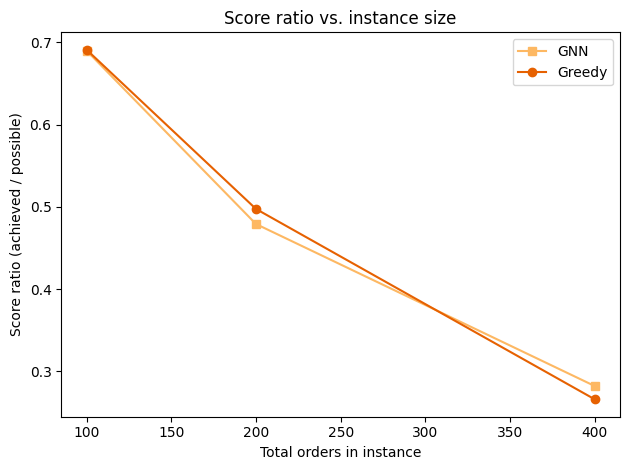

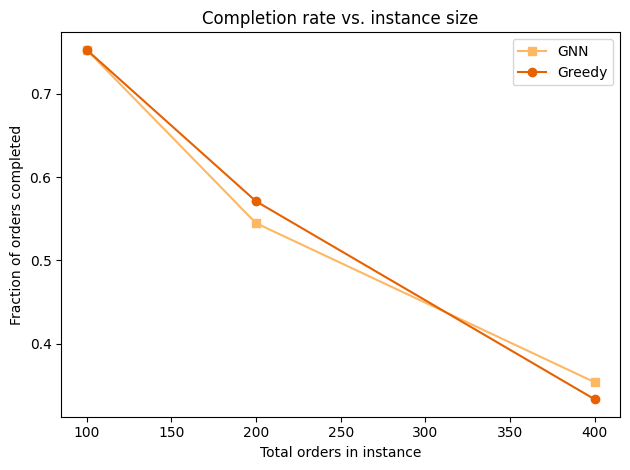

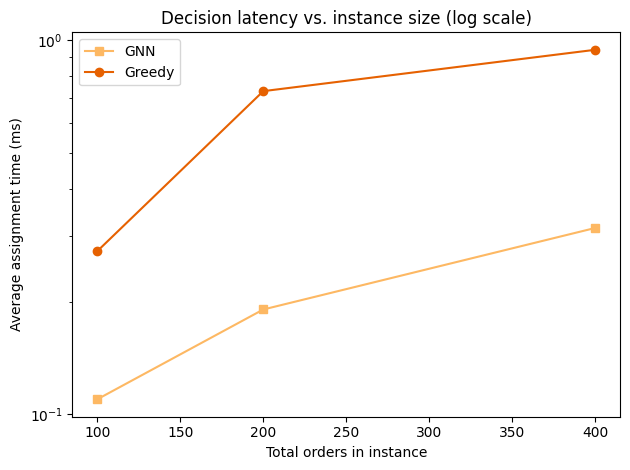

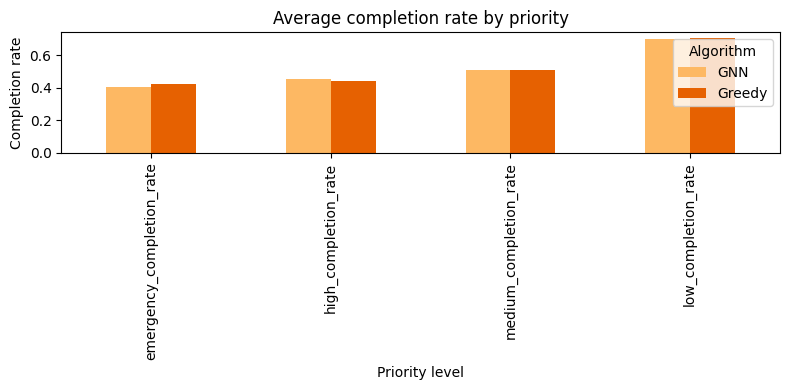


=== Key KPIs by algorithm & instance size ===
                  score_ratio  completion_rate  avg_delivery_time  \
algorithm size                                                      
GNN       large         0.282            0.354              6.755   
          medium        0.479            0.545              4.966   
          small         0.690            0.753              3.163   
Greedy    large         0.266            0.333              6.868   
          medium        0.497            0.571              4.993   
          small         0.691            0.753              3.171   

                  avg_assignment_ms  
algorithm size                       
GNN       large               0.315  
          medium              0.191  
          small               0.110  
Greedy    large               0.941  
          medium              0.730  
          small               0.273  

Wrote summary table to 'algorithm_size_summary.csv'


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------------------------
# 1. Load and combine the two result files
# --------------------------------------------------------------------
greedy_df = pd.read_csv(Path('results/batch_summary_20250709_150901.csv'))

#gnn_df    = pd.read_csv(Path('GNN_results/advanced_gnn_batch_summary_20250709_154036.csv'))

gnn_df    = pd.read_csv(Path('GNN_results/advanced_gnn_batch_summary_20250709_164816.csv'))

greedy_df['algorithm'] = 'Greedy'
gnn_df['algorithm']    = 'GNN'

df = pd.concat([greedy_df, gnn_df], ignore_index=True)

# You may want to add these convenience ratios if they are not in the CSVs
df['score_ratio']      = df['total_score_achieved'] / df['total_possible_score']
df['completion_rate']  = df['orders_completed']     / df['total_orders']

# --------------------------------------------------------------------
# 2. Helper for nicer colours / markers (optional)
# --------------------------------------------------------------------
palette = {'Greedy': '#e66101', 'GNN': '#fdb863'}  # feel free to change
markers = {'Greedy': 'o',       'GNN': 's'}

# --------------------------------------------------------------------
# 3. SCORE RATIO vs. INSTANCE SIZE
# --------------------------------------------------------------------
plt.figure()
for alg, grp in df.groupby('algorithm'):
    (grp.groupby('total_orders')['score_ratio']
        .mean()
        .sort_index()
        .plot(marker=markers[alg], label=alg, color=palette[alg]))
plt.xlabel('Total orders in instance')
plt.ylabel('Score ratio (achieved / possible)')
plt.title('Score ratio vs. instance size')
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 4. COMPLETION RATE vs. INSTANCE SIZE
# --------------------------------------------------------------------
plt.figure()
for alg, grp in df.groupby('algorithm'):
    (grp.groupby('total_orders')['completion_rate']
        .mean()
        .sort_index()
        .plot(marker=markers[alg], label=alg, color=palette[alg]))
plt.xlabel('Total orders in instance')
plt.ylabel('Fraction of orders completed')
plt.title('Completion rate vs. instance size')
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 5. DECISION LATENCY (log-scale)
# --------------------------------------------------------------------
plt.figure()
for alg, grp in df.groupby('algorithm'):
    (grp.groupby('total_orders')['average_assignment_time_ms']
        .mean()
        .sort_index()
        .plot(marker=markers[alg], label=alg, color=palette[alg]))
plt.yscale('log')
plt.xlabel('Total orders in instance')
plt.ylabel('Average assignment time (ms)')
plt.title('Decision latency vs. instance size (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 6. PRIORITY-LEVEL COMPLETION RATES
# --------------------------------------------------------------------
priority_cols = ['emergency_completion_rate',
                 'high_completion_rate',
                 'medium_completion_rate',
                 'low_completion_rate']

priority_rates = (df
                  .groupby('algorithm')[priority_cols]
                  .mean()
                  .T  # transpose so priorities are rows
                  )

priority_rates.plot(kind='bar',
                    figsize=(8,4),
                    color=[palette[c] for c in priority_rates.columns])
plt.xlabel('Priority level')
plt.ylabel('Completion rate')
plt.title('Average completion rate by priority')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 7. PRINT / SAVE A TABULAR SUMMARY
# --------------------------------------------------------------------
summary = (df.groupby(['algorithm', 'size'])
             .agg(score_ratio=('score_ratio',            'mean'),
                  completion_rate=('completion_rate',    'mean'),
                  avg_delivery_time=('average_delivery_time', 'mean'),
                  avg_assignment_ms=('average_assignment_time_ms','mean'))
             .round(3))

print('\n=== Key KPIs by algorithm & instance size ===')
print(summary)

# Optional: write to CSV so you can drop it into a paper/table
summary.to_csv('algorithm_size_summary.csv')
print("\nWrote summary table to 'algorithm_size_summary.csv'")

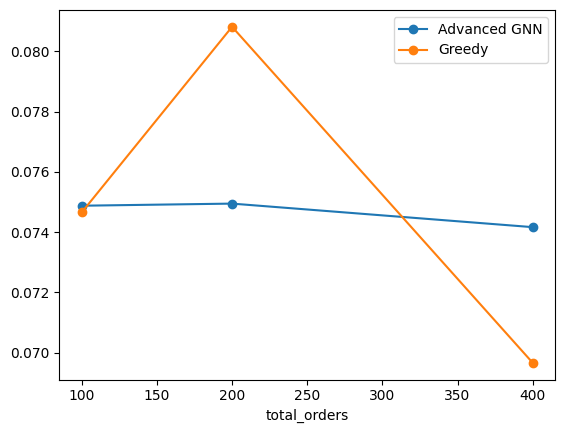

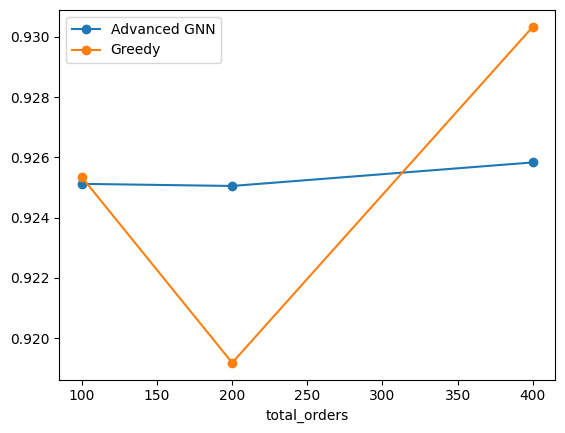

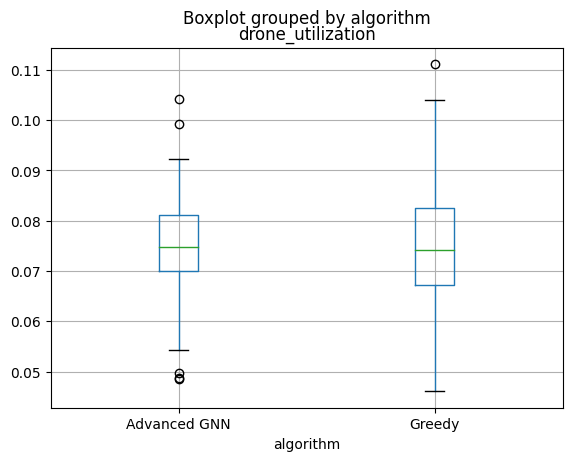

In [2]:
import pandas as pd, matplotlib.pyplot as plt
greedy = pd.read_csv('results/batch_summary_20250709_150901.csv')
# gnn    = pd.read_csv('GNN_results/advanced_gnn_batch_summary_20250709_154036.csv')

gnn = pd.read_csv('GNN_results/advanced_gnn_batch_summary_20250709_164816.csv')

greedy['algorithm'] = 'Greedy'; gnn['algorithm'] = 'Advanced GNN'

for df in (greedy, gnn):
    df['idle_fraction'] = df['total_idle_time_hours'] / \
        (df['total_idle_time_hours'] + df['total_flight_time_hours'])

df = pd.concat([greedy, gnn])

# utilisation-vs-orders
for alg, grp in df.groupby('algorithm'):
    grp.groupby('total_orders')['drone_utilization'].mean().plot(marker='o', label=alg)
plt.legend(); plt.show()
# idle-vs-orders
for alg, grp in df.groupby('algorithm'):
    grp.groupby('total_orders')['idle_fraction'].mean().plot(marker='o', label=alg)
plt.legend(); plt.show()
# box-plot
df.boxplot(column='drone_utilization', by='algorithm'); plt.show()

In [3]:
import pandas as pd

# Load the CSV files
df_gnn = pd.read_csv("GNN_results/gnn_approach.csv")
df_greedy = pd.read_csv("results/greedy_approach.csv")

# Add approach column
df_gnn['approach'] = 'GNN'
df_greedy['approach'] = 'Greedy'

# Concatenate the dataframes
df_combined = pd.concat([df_gnn, df_greedy], ignore_index=True)

# Filter out instances ending with _0
df_filtered = df_combined[~df_combined['instance_name'].str.endswith('_0')]

# Define the metrics
metrics = ['total_idle_time_hours', 'average_assignment_time_ms', 'orders_completed', 'orders_failed']

# Group by region, size, and approach, and compute the mean for the metrics
df_grouped = df_filtered.groupby(['region', 'size', 'approach'])[metrics].mean()

# Unstack the approach level to make it columns
df_table = df_grouped.unstack('approach')

# Round the values to 2 decimal places
df_table = df_table.round(2)

# Print the table
print(df_table)

                      total_idle_time_hours          \
approach                                GNN  Greedy   
region         size                                   
arkansas       large                 141.37  146.89   
               medium                 76.04   79.15   
               small                  28.12   28.55   
north_carolina large                 136.90  141.60   
               medium                 78.65   72.28   
               small                  28.17   27.72   
texas          large                 143.79  139.56   
               medium                 73.75   75.79   
               small                  28.26   28.26   
utah           large                 140.54  143.94   
               medium                 77.07   72.71   
               small                  28.71   28.70   

                      average_assignment_time_ms        orders_completed  \
approach                                     GNN Greedy              GNN   
region         size   

Aggregate performance by instance size:
        total_idle_time_hours_Greedy  average_assignment_time_ms_Greedy  \
size                                                                      
small                          28.30                               0.05   
medium                         74.98                               0.13   
large                         143.00                               0.25   

        orders_completed_Greedy  orders_failed_Greedy  \
size                                                    
small                     74.75                 10.00   
medium                   114.38                 12.69   
large                    131.50                 17.00   

        total_idle_time_hours_GNN  average_assignment_time_ms_GNN  \
size                                                                
small                       28.31                            0.11   
medium                      76.38                            0.19   
large                 

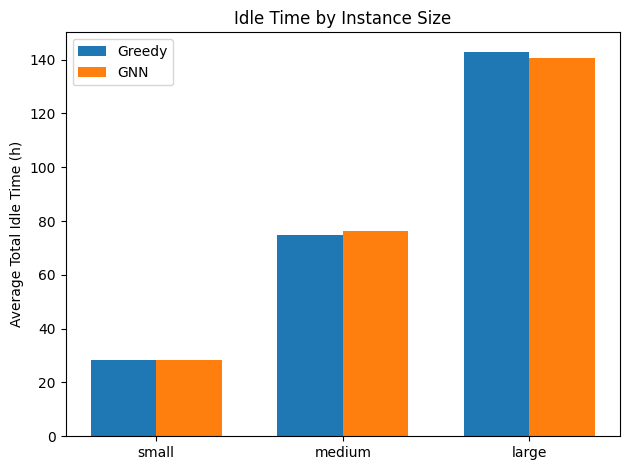

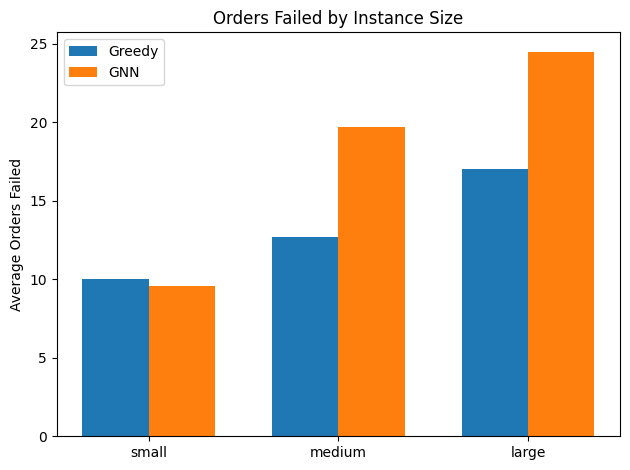

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
greedy_df = pd.read_csv('results/greedy_approach.csv')
gnn_df = pd.read_csv('GNN_results/gnn_approach.csv')

# Filter out instances ending with "_0"
greedy_df = greedy_df[~greedy_df['instance_name'].str.endswith('_0')]
gnn_df = gnn_df[~gnn_df['instance_name'].str.endswith('_0')]

metrics = ['total_idle_time_hours', 'average_assignment_time_ms', 'orders_completed', 'orders_failed']

# Aggregate by size across regions
agg_size_greedy = greedy_df.groupby('size')[metrics].mean().reindex(['small', 'medium', 'large'])
agg_size_gnn = gnn_df.groupby('size')[metrics].mean().reindex(['small', 'medium', 'large'])

# Combine for quick inspection
summary = pd.concat([agg_size_greedy.add_suffix('_Greedy'),
                     agg_size_gnn.add_suffix('_GNN')], axis=1)

print("Aggregate performance by instance size:")
print(summary.round(2))

# Plot 1 – Idle Time Comparison
plt.figure()
sizes = ['small', 'medium', 'large']
x = range(len(sizes))
plt.bar(x, summary['total_idle_time_hours_Greedy'], width=0.35, label='Greedy')
plt.bar([i + 0.35 for i in x], summary['total_idle_time_hours_GNN'], width=0.35, label='GNN')
plt.xticks([i + 0.175 for i in x], sizes)
plt.ylabel('Average Total Idle Time (h)')
plt.title('Idle Time by Instance Size')
plt.legend()
plt.tight_layout()
plt.savefig('idle_time_comparison.png')
plt.show()

# Plot 2 – Orders Failed Comparison
plt.figure()
plt.bar(x, summary['orders_failed_Greedy'], width=0.35, label='Greedy')
plt.bar([i + 0.35 for i in x], summary['orders_failed_GNN'], width=0.35, label='GNN')
plt.xticks([i + 0.175 for i in x], sizes)
plt.ylabel('Average Orders Failed')
plt.title('Orders Failed by Instance Size')
plt.legend()
plt.tight_layout()
plt.savefig('orders_failed_comparison.png')
plt.show()